###**1. Image Inpainting **

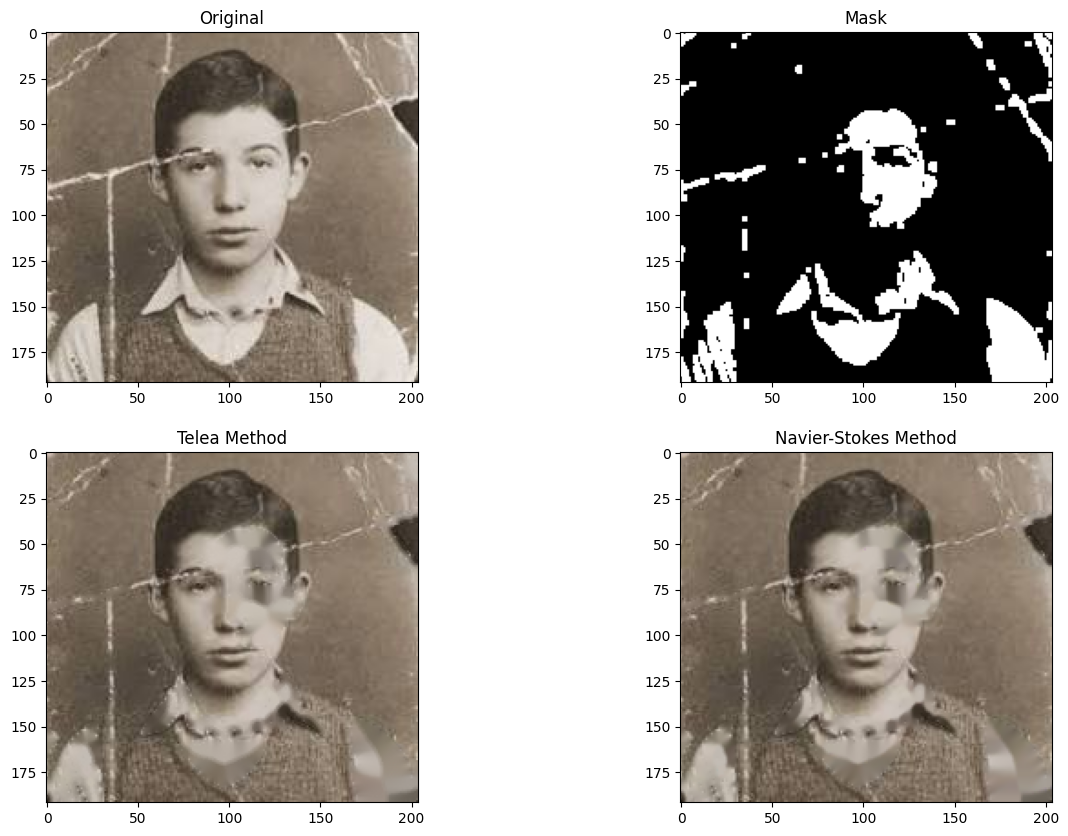

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the damaged image
image = cv2.imread('/content/Damaged.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a mask where white represents the damaged areas
# (You'll need to adjust this based on your specific image)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


# Dilate the mask to cover more area around the scratches
kernel = np.ones((3,3), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=1)

# Apply inpainting
result_telea = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)
result_ns = cv2.inpaint(image, mask, 3, cv2.INPAINT_NS)

# Display results
plt.figure(figsize=(15,10))
plt.subplot(221), plt.imshow(image), plt.title('Original')
plt.subplot(222), plt.imshow(mask, cmap='gray'), plt.title('Mask')
plt.subplot(223), plt.imshow(result_telea), plt.title('Telea Method')
plt.subplot(224), plt.imshow(result_ns), plt.title('Navier-Stokes Method')
plt.show()

###**2. Image Stitching/Panorama**

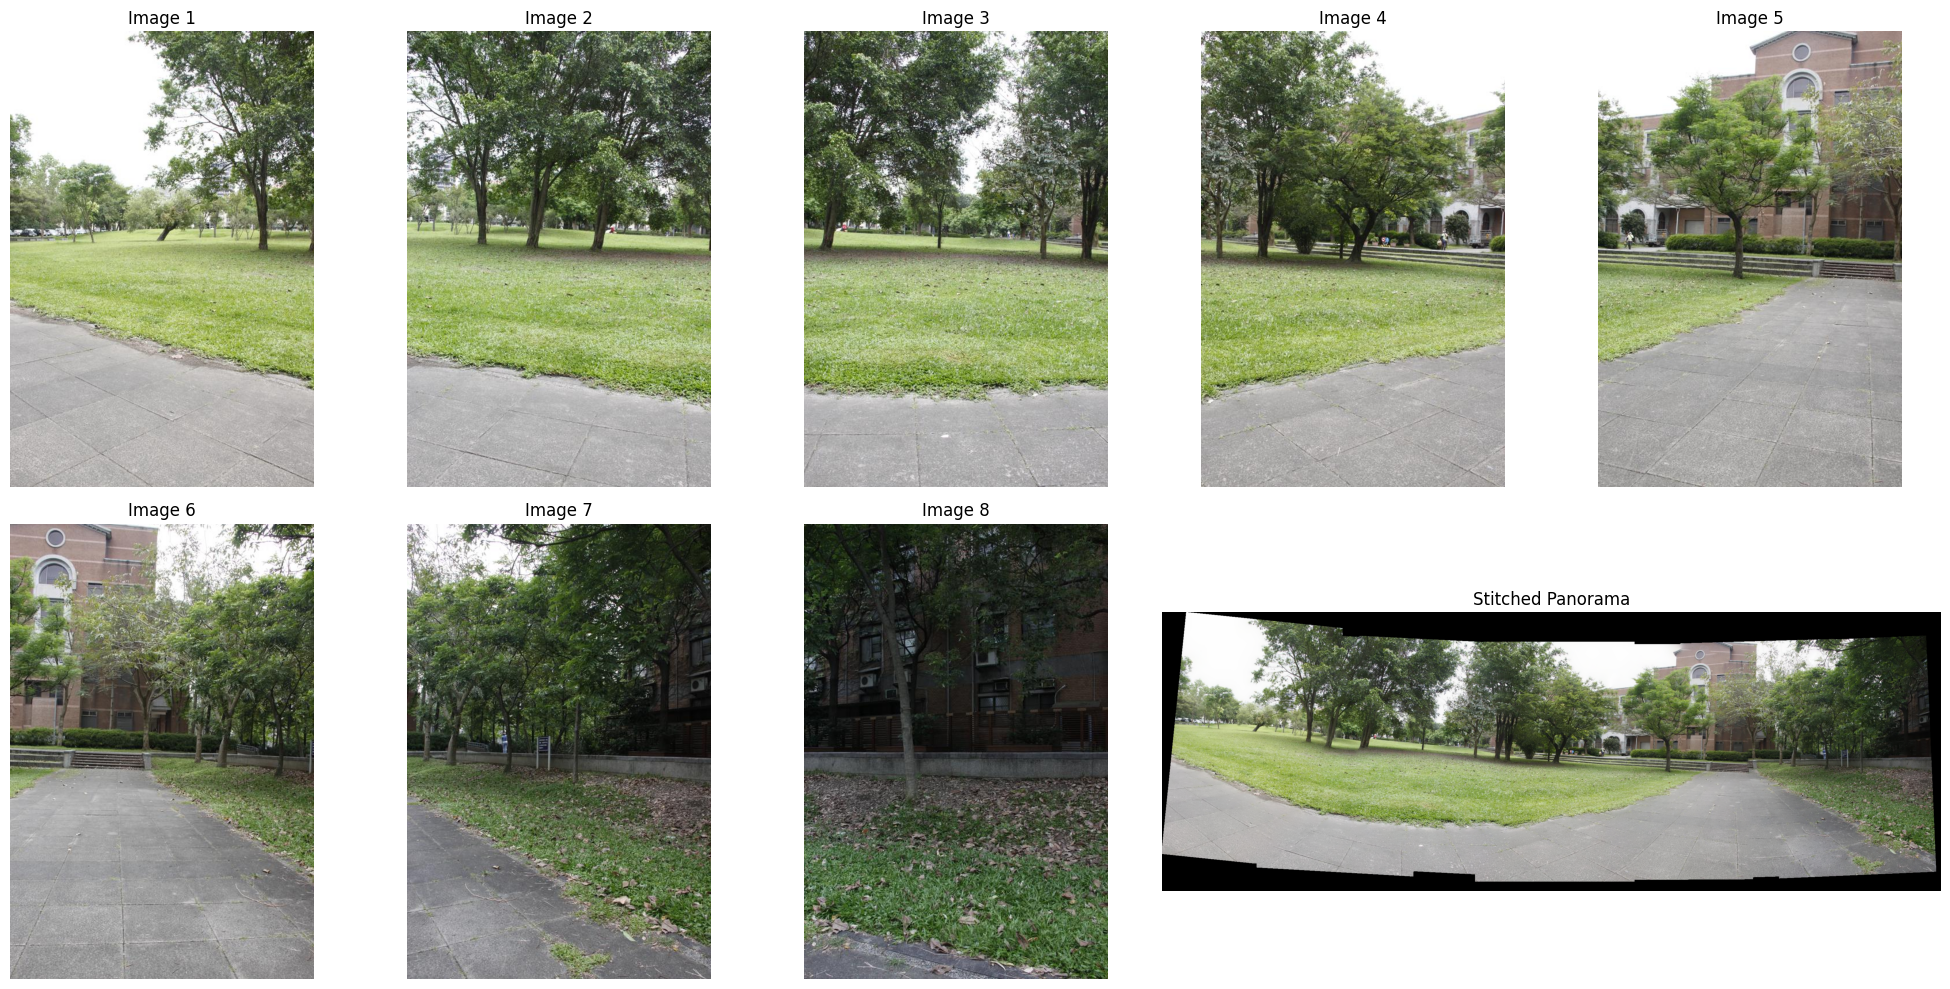

Panorama saved as panorama_result.jpg


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load all 8 images
images = []
images_rgb = []

for i in range(1, 9):
    img = cv2.imread(f'{i}.jpg')
    if img is None:
        print(f"Error: Could not load image overlap{i}.jpg")
        exit()
    images.append(img)
    images_rgb.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Initialize OpenCV's stitcher with higher confidence threshold
stitcher = cv2.Stitcher_create(cv2.Stitcher_SCANS)  # Use SCANS mode for more images
stitcher.setPanoConfidenceThresh(0.5)  # Lower threshold to handle more images

# Try stitching with different subsets if full set fails
status, stitched = stitcher.stitch(images)

if status == cv2.Stitcher_OK:
    # Convert to RGB for display
    stitched_rgb = cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB)

    # Display results
    plt.figure(figsize=(20, 10))

    # Display all input images in a row
    for i in range(8):
        plt.subplot(2, 5, i+1)
        plt.imshow(images_rgb[i])
        plt.title(f'Image {i+1}')
        plt.axis('off')

    # Display stitched result
    plt.subplot(2, 5, (9,10))  # Span the last two columns
    plt.imshow(stitched_rgb)
    plt.title('Stitched Panorama')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Save the result
    cv2.imwrite('panorama_result.jpg', cv2.cvtColor(stitched_rgb, cv2.COLOR_RGB2BGR))
    print("Panorama saved as panorama_result.jpg")
else:
    print(f"Stitching failed with error code {status}")

    # Try fallback strategy - stitch in smaller groups
    print("Attempting fallback strategy: stitching in smaller groups...")

    # Split into two groups of 4 images each
    group1 = images[:4]
    group2 = images[4:]

    # Stitch first group
    status1, stitched1 = stitcher.stitch(group1)
    status2, stitched2 = stitcher.stitch(group2)

    if status1 == cv2.Stitcher_OK and status2 == cv2.Stitcher_OK:
        # Now stitch the two partial panoramas
        status_final, stitched_final = stitcher.stitch([stitched1, stitched2])

        if status_final == cv2.Stitcher_OK:
            stitched_final_rgb = cv2.cvtColor(stitched_final, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(15, 5))
            plt.imshow(stitched_final_rgb)
            plt.title('Final Stitched Panorama (Fallback Method)')
            plt.axis('off')
            plt.show()

            cv2.imwrite('panorama_fallback_result.jpg',
                        cv2.cvtColor(stitched_final_rgb, cv2.COLOR_RGB2BGR))
            print("Fallback panorama saved as panorama_fallback_result.jpg")
        else:
            print(f"Final stitching failed with error code {status_final}")
    else:
        print(f"Group stitching failed (Group1: {status1}, Group2: {status2})")

###**3. Structure from Motion**

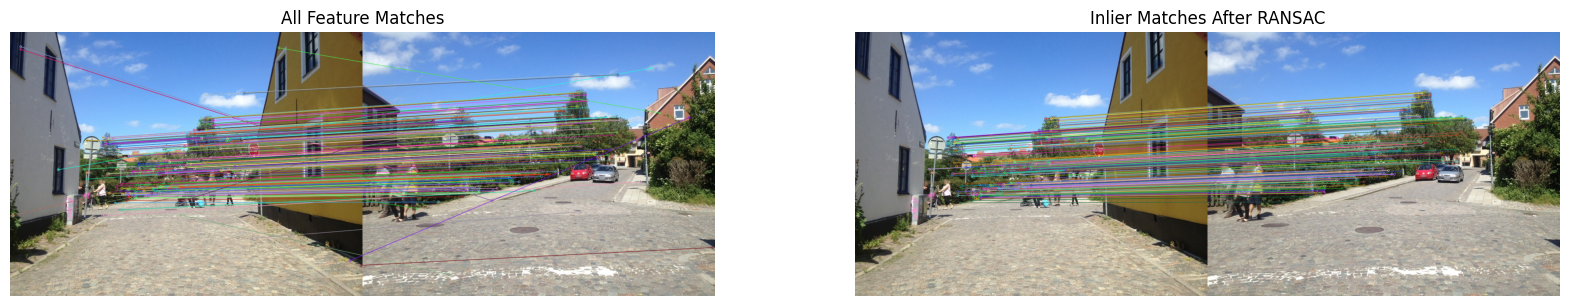

<ipython-input-4-1bb6daa23eb0>:77: RuntimeWarning: divide by zero encountered in divide
  pts3d = pts4d[:3] / pts4d[3]
<ipython-input-4-1bb6daa23eb0>:77: RuntimeWarning: overflow encountered in divide
  pts3d = pts4d[:3] / pts4d[3]
<ipython-input-4-1bb6daa23eb0>:77: RuntimeWarning: invalid value encountered in divide
  pts3d = pts4d[:3] / pts4d[3]


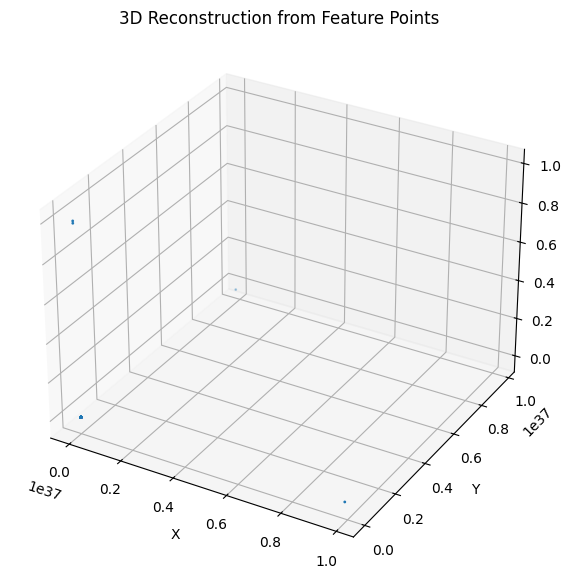

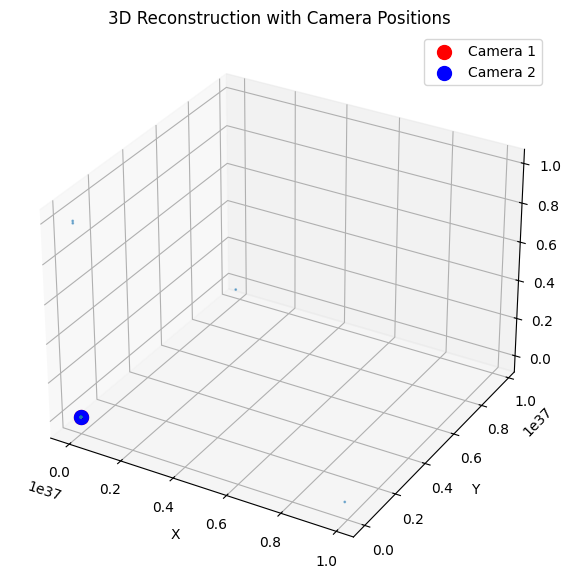

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load images
img1 = cv2.imread('23.jpg', 0)
img2 = cv2.imread('24.jpg', 0)

# Create color versions for display
img1_color = cv2.cvtColor(cv2.imread('23.jpg'), cv2.COLOR_BGR2RGB)
img2_color = cv2.cvtColor(cv2.imread('24.jpg'), cv2.COLOR_BGR2RGB)

# Feature detection
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Feature matching
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

# Draw matches
img_matches = cv2.drawMatches(img1_color, kp1, img2_color, kp2, good, None,
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Find fundamental matrix
pts1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# Draw inlier matches
img_inlier_matches = cv2.drawMatches(img1_color, kp1, img2_color, kp2,
                                   [good[i] for i in range(len(good)) if mask.ravel()[i]==1],
                                   None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display original images and matches
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_matches)
plt.title('All Feature Matches')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_inlier_matches)
plt.title('Inlier Matches After RANSAC')
plt.axis('off')
plt.show()

# Camera intrinsics (you'll need to calibrate your camera or make reasonable assumptions)
K = np.array([[800, 0, 320], [0, 800, 240], [0, 0, 1]])

# Essential matrix
E = K.T @ F @ K

# Recover pose
_, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)

# Triangulate points
proj1 = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
proj2 = np.hstack((R, t))
proj1 = K @ proj1
proj2 = K @ proj2

pts4d = cv2.triangulatePoints(proj1, proj2, pts1.T, pts2.T)
pts3d = pts4d[:3] / pts4d[3]

# Visualize 3D points
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts3d[0], pts3d[1], pts3d[2], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Reconstruction from Feature Points')
plt.show()

# Display camera positions
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts3d[0], pts3d[1], pts3d[2], s=1, alpha=0.5)

# Draw camera positions and orientations
camera1_pos = np.array([0, 0, 0])
camera2_pos = -R.T @ t.ravel()

ax.scatter(camera1_pos[0], camera1_pos[1], camera1_pos[2], c='r', s=100, label='Camera 1')
ax.scatter(camera2_pos[0], camera2_pos[1], camera2_pos[2], c='b', s=100, label='Camera 2')

# Draw camera frustums (simplified)
def draw_camera(ax, pos, R, color, length=0.5):
    # Camera axes
    axes = np.eye(3) @ R.T
    for i in range(3):
        ax.quiver(pos[0], pos[1], pos[2],
                 axes[0,i], axes[1,i], axes[2,i],
                 length=length, color=color, arrow_length_ratio=0.1)

    # Simple frustum
    corners = np.array([[0,0,1], [1,1,1], [-1,1,1], [-1,-1,1], [1,-1,1]])
    corners = corners * length
    corners = corners @ R.T + pos
    ax.plot([pos[0], corners[0,0]], [pos[1], corners[0,1]], [pos[2], corners[0,2]], color+'--')
    for i in range(1,5):
        ax.plot([pos[0], corners[i,0]], [pos[1], corners[i,1]], [pos[2], corners[i,2]], color+'--')
        ax.plot([corners[i,0], corners[i%4+1,0]], [corners[i,1], corners[i%4+1,1]],
                [corners[i,2], corners[i%4+1,2]], color+'-')

draw_camera(ax, camera1_pos, np.eye(3), 'r')
draw_camera(ax, camera2_pos, R, 'b')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('3D Reconstruction with Camera Positions')
plt.show()